# Imports:

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from torchsummary import summary
import torchinfo
import moabb

C:\Users\bijan\AppData\Roaming\Python\Python39\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

["'pwd' is not recognized as an internal or external command,",
 'operable program or batch file.']

# Functions:

In [3]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [4]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [5]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [28]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)

        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [7]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [8]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

In [9]:
def slicer(epochs, num_splits):
    split_length = int(epochs.shape[2] / num_splits)
    channels = epochs.shape[1]
    num_epochs = epochs.shape[0]
    start = 0
    new_epochs = np.zeros((num_epochs, num_splits, channels, split_length))
    #new_labels = np.tile(labels, (1, num_splits))
    for i in range(num_splits):
        new_epochs[:, i, :, :] = epochs[:, :, (i * split_length) : ((i+1) * split_length)]
    
    return new_epochs

# Test case for slicer function:

In [10]:
sample_epoch = np.random.rand(5, 10, 10)
print(sample_epoch.shape)
sample_label = np.random.randint(1, 4, (5, 1))
sample_label

(5, 10, 10)


array([[1],
       [3],
       [3],
       [1],
       [2]])

In [11]:
new_epoch = slicer(sample_epoch, num_splits=5)
new_epoch.shape

(5, 5, 10, 2)

# Device (GPU\CPU\MPS)

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Simple CNN Model (Feature-Based):

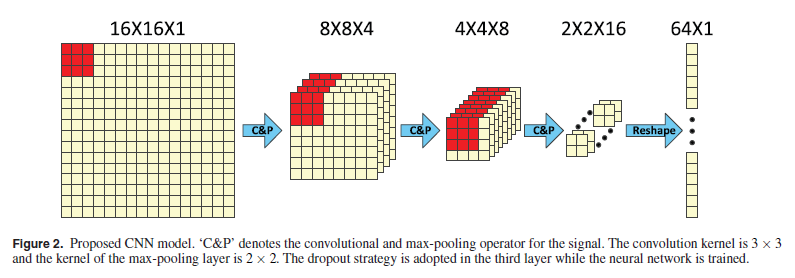

In [13]:
class simple_CNN(torch.nn.Module):
    def __init__(self):
        super(simple_CNN, self).__init__()
        
        self.batch2d = nn.BatchNorm2d(1)
        
        self.CNN_2_1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding='same')
        self.Pool_2_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation_2_1 = nn.ReLU()
        
        self.CNN_2_2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding='same')
        self.Pool_2_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation_2_2 = nn.ReLU()
        
        self.CNN_2_3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding='same')
        self.Pool_2_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation_2_3 = nn.ReLU()
        
        
        self.dropout = nn.Dropout(0.5)
        self.linear_3_1 = nn.Linear(64, 64)
        self.activation_3_1 = nn.ReLU()
        self.linear_3_2 = nn.Linear(64, 16)
        self.activation_3_2 = nn.ReLU()
        self.linear_3_3 = nn.Linear(16, 4)
        self.activation_3_3 = nn.Softmax(dim=1)
        self.activation_3_4 = nn.Softmax(dim=0)
        
    def forward(self, x):
        
        
        cnn2 = x.unsqueeze(1)
        cnn2 = self.batch2d(x)
        cnn2 = self.CNN_2_1(cnn2)
        cnn2 = self.activation_2_1(cnn2)
        cnn2 = self.Pool_2_1(cnn2)


        
        cnn2 = self.CNN_2_2(cnn2)
        cnn2 = self.activation_2_2(cnn2)
        cnn2 = self.Pool_2_2(cnn2)
        

        
        cnn2 = self.CNN_2_3(cnn2)
        cnn2 = self.activation_2_3(cnn2)
        cnn2 = self.Pool_2_3(cnn2)
        

        
        if cnn2.shape[0] == 1:
            dim_num = 0
            
        else:
            dim_num = 1
        
        output = cnn2.view(x.shape[0], -1)

        output = self.linear_3_1(output)
        output = self.activation_3_1(output)
        output = self.dropout(output)
        output = self.linear_3_2(output)
        output = self.activation_3_2(output)
        output = self.dropout(output)
        output = self.linear_3_3(output)
        
        output = self.activation_3_3(output)
        
        return output
        

In [14]:
model = simple_CNN()
r_sample = torch.rand(10, 1, 16, 16)
#print(r_sample[:, 0, :].shape)
model(r_sample)

tensor([[0.3120, 0.1912, 0.2109, 0.2858],
        [0.2989, 0.2063, 0.2158, 0.2790],
        [0.3262, 0.1893, 0.2082, 0.2762],
        [0.3306, 0.1872, 0.1987, 0.2834],
        [0.3193, 0.1893, 0.2133, 0.2781],
        [0.3126, 0.1999, 0.2069, 0.2807],
        [0.3292, 0.1835, 0.2019, 0.2854],
        [0.2896, 0.2031, 0.2330, 0.2743],
        [0.3281, 0.1922, 0.2002, 0.2796],
        [0.3156, 0.1930, 0.2082, 0.2832]], grad_fn=<SoftmaxBackward0>)

In [15]:
import torch
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the model
model = simple_CNN()
model.to(device)

# Set input size for a single sample (assuming input shape is (channels, height, width))
input_size = (1, 1, 16, 16)  # Adjust this according to your actual input shape

# Generate model summary
torchinfo.summary(model, input_size=input_size, device=device)


Layer (type:depth-idx)                   Output Shape              Param #
simple_CNN                               [1, 4]                    --
├─BatchNorm2d: 1-1                       [1, 1, 16, 16]            2
├─Conv2d: 1-2                            [1, 4, 16, 16]            40
├─ReLU: 1-3                              [1, 4, 16, 16]            --
├─MaxPool2d: 1-4                         [1, 4, 8, 8]              --
├─Conv2d: 1-5                            [1, 8, 8, 8]              296
├─ReLU: 1-6                              [1, 8, 8, 8]              --
├─MaxPool2d: 1-7                         [1, 8, 4, 4]              --
├─Conv2d: 1-8                            [1, 16, 4, 4]             1,168
├─ReLU: 1-9                              [1, 16, 4, 4]             --
├─MaxPool2d: 1-10                        [1, 16, 2, 2]             --
├─Linear: 1-11                           [1, 64]                   4,160
├─ReLU: 1-12                             [1, 64]                   --
├─Dropout

# Data reading:

In [16]:
raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"

try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf"
            

except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"
    
    

data_epochs = []
data_labels = []


for participant_id in range(1, 10):
    participant_E = f"A0{participant_id}E"
    participant_T = f"A0{participant_id}T"

    file_path_E = f"{raw_data_path}/{participant_E}.gdf"
    file_path_T = f"{raw_data_path}/{participant_T}.gdf"

    raw_train = mne.io.read_raw_gdf(file_path_T, preload=True)
    raw_test = mne.io.read_raw_gdf(file_path_E, preload=True)


    train_events = mne.events_from_annotations(raw_train)
    test_events = mne.events_from_annotations(raw_test)

    train_epochs, train_labels = epoch_label_extractor(raw_train, train_events, epoch_length = 4, num_channels = 22, sampling_freq = 250)

    new_epochs = slicer(train_epochs, num_splits=1)
    
    data_epochs.append(new_epochs)
    data_labels.append(train_labels)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


In [17]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), data_labels[i].shape)


Subject 1 train epochs:     (288, 1, 22, 1000)     Subject 1 train labels:     (288, 1)
Subject 2 train epochs:     (288, 1, 22, 1000)     Subject 2 train labels:     (288, 1)
Subject 3 train epochs:     (288, 1, 22, 1000)     Subject 3 train labels:     (288, 1)
Subject 4 train epochs:     (144, 1, 22, 1000)     Subject 4 train labels:     (144, 1)
Subject 5 train epochs:     (288, 1, 22, 1000)     Subject 5 train labels:     (288, 1)
Subject 6 train epochs:     (288, 1, 22, 1000)     Subject 6 train labels:     (288, 1)
Subject 7 train epochs:     (288, 1, 22, 1000)     Subject 7 train labels:     (288, 1)
Subject 8 train epochs:     (288, 1, 22, 1000)     Subject 8 train labels:     (288, 1)
Subject 9 train epochs:     (288, 1, 22, 1000)     Subject 9 train labels:     (288, 1)


In [18]:
# all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
# all_data_labels = np.zeros(len(train_data_epochs)).tolist()

# for i in range(len(train_data_epochs)):
#     all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
#     all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)


all_data_epochs = data_epochs
all_data_labels = data_labels

In [19]:
# # Checking if the concatenation does not have a problem!

# print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
# print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
# print("\n\n")
# print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
# print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

In [20]:
all_data_labels[0][:, 0]

array([3, 2, 1, 0, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 1, 3,
       3, 2, 0, 3, 3, 1, 3, 3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2,
       3, 1, 2, 0, 0, 0, 3, 1, 0, 2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3,
       3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 3, 1,
       3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3, 0, 0, 2, 1, 3, 3, 3, 1,
       0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1, 0, 0, 3, 1, 0, 2,
       1, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 3, 0, 3,
       0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3,
       0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0,
       0, 2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2,
       1, 0, 3, 0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2, 0, 3,
       1, 3, 3, 2, 3, 3, 2, 1, 3, 2, 0, 1, 1, 1, 2, 1, 3, 2, 3, 1, 2, 0,
       3, 0, 2, 3, 0, 2, 0, 1, 1, 0, 3, 0, 3, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 0])

In [21]:
for i in range(len(all_data_epochs)):
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (288, 1, 22, 1000)     All label shape (sub 0):      (288, 1)
All data epoch shape (sub 1):     (288, 1, 22, 1000)     All label shape (sub 1):      (288, 1)
All data epoch shape (sub 2):     (288, 1, 22, 1000)     All label shape (sub 2):      (288, 1)
All data epoch shape (sub 3):     (144, 1, 22, 1000)     All label shape (sub 3):      (144, 1)
All data epoch shape (sub 4):     (288, 1, 22, 1000)     All label shape (sub 4):      (288, 1)
All data epoch shape (sub 5):     (288, 1, 22, 1000)     All label shape (sub 5):      (288, 1)
All data epoch shape (sub 6):     (288, 1, 22, 1000)     All label shape (sub 6):      (288, 1)
All data epoch shape (sub 7):     (288, 1, 22, 1000)     All label shape (sub 7):      (288, 1)
All data epoch shape (sub 8):     (288, 1, 22, 1000)     All label shape (sub 8):      (288, 1)


In [22]:
all_data_labels[1][:10]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [2],
       [1],
       [3]])

# Encoding

In [23]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [24]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (144, 1)
Participant 16 - labels[0] shape: (144, 4)



Participant 16 - labels[0]:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# Feature Extraction:

In [29]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Train epochs shape:  ", train_epochs.shape)
    print("Test epochs shape:  ", test_epochs.shape)
    
    #original_stdout = sys.stdout
    #sys.stdout = open('temp_stdout{}.txt'.format(i+10000), 'w')  # Redirect output to a temporary file
    mne.set_log_level('warning')
    train_features, test_features = feature_extraction_4(train_epochs, no_encoded_train_labels, test_epochs, sampling_freq = 250, n_components=16)
    #sys.stdout.close()
    #sys.stdout = original_stdout
    
    
    print("Train features shape:", train_features.shape)
    print("Test features shape:", test_features.shape)
    
    
    
        
    with open("test_index_loop_{}_NoSlice.pickle".format(test_index[0]), "wb") as f:
        pickle.dump(test_index, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    
    with open("train_features_fortestID_{}_NoSlice.pickle".format(test_index[0]), "wb") as f:
        pickle.dump(train_features, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
        
    with open("test_features_fortestID_{}_NoSlice.pickle".format(test_index[0]), "wb") as f:
        pickle.dump(test_features, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    print("The {}th run out of 9 is done!".format(i))

Train epochs shape:   (2160, 1, 22, 1000)
Test epochs shape:   (288, 1, 22, 1000)
Time taken for csp calculations:  6.000922441482544
Time taken for csp calculations:  5.453761577606201
Time taken for csp calculations:  5.350107908248901
Time taken for csp calculations:  5.423413515090942
Time taken for csp calculations:  5.435408115386963
Time taken for csp calculations:  5.477493047714233
Time taken for csp calculations:  5.3717262744903564
Time taken for csp calculations:  5.3866126537323
Time taken for csp calculations:  5.373676538467407
Time taken for csp calculations:  5.369834899902344
Time taken for csp calculations:  5.314549207687378
Time taken for csp calculations:  5.146198987960815
Time taken for csp calculations:  5.259361982345581
Time taken for csp calculations:  5.552401304244995
Time taken for csp calculations:  5.3572540283203125
Time taken for csp calculations:  5.658405065536499
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train features shape: (2160

# Within Subject:

In [ ]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []





for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        # Create the EEGNet model
        model = XGBClassifier()




        #     # Normalizing the features
        #     mean = train_epochs.mean(axis=(0, 2), keepdims=True)
        #     std = train_epochs.std(axis=(0, 2), keepdims=True)

        #     print(mean.shape)
        #     print(std.shape)

        #     norm_train_epochs = (train_epochs - mean) / std
        #     norm_test_epochs = (test_epochs - mean) / std
        #     # Commented the normalization part since it reduces the rank of data and rasing errors with 
        #     # CSP filter bank

        train_features, test_features = feature_extraction_4(train_epochs, no_encoded_train_labels, test_epochs, sampling_freq = 250)
        print("Train features shape:", train_features.shape)
        print("Test features shape:", test_features.shape)

        # Train the model
        model.fit(train_features, no_encoded_train_labels[:, 0])

        # Test the model
        y_pred = model.predict(test_features)
        
        tests_pred.append(y_pred)
        tests_true.append(no_encoded_test_labels[:, 0])
    
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [ ]:
print(len(all_tests_pred))

In [20]:
print(np.concatenate(all_tests_pred[4]).shape)

(288,)


In [21]:
for i in range(len(all_tests_true)):
   print(all_tests_true[i])


[array([0, 2, 1, 3, 2, 0, 1, 0, 0, 1, 0, 1, 2, 3, 3, 2, 3, 3, 1, 1, 1, 2,
       3, 2, 0, 3, 3, 0, 1, 0, 1, 2, 1, 0, 2, 2, 2, 3, 0, 1, 3, 1, 3, 1,
       2, 3, 0, 1, 3, 2, 1, 3, 0, 2, 2, 0, 3, 0]), array([0, 0, 1, 3, 2, 1, 2, 3, 0, 3, 0, 2, 3, 3, 2, 1, 3, 1, 3, 0, 1, 3,
       1, 1, 2, 3, 0, 1, 3, 1, 3, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 2, 2,
       3, 3, 2, 1, 1, 2, 0, 3, 0, 3, 2, 2, 0, 1]), array([2, 3, 0, 2, 3, 2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 3, 0, 1, 3, 0, 1, 1,
       2, 1, 0, 0, 3, 2, 0, 2, 1, 3, 2, 1, 1, 3, 3, 2, 0, 3, 3, 2, 0, 3,
       2, 1, 3, 1, 3, 0, 0, 1, 1, 3, 0, 1, 2, 0]), array([1, 1, 0, 1, 3, 3, 3, 2, 2, 3, 2, 2, 0, 2, 3, 0, 1, 0, 2, 0, 1, 1,
       0, 2, 2, 0, 0, 2, 2, 1, 2, 1, 3, 0, 3, 1, 1, 2, 3, 3, 0, 3, 1, 3,
       1, 0, 0, 1, 3, 0, 3, 3, 1, 2, 2, 2, 0]), array([3, 0, 2, 0, 1, 0, 3, 3, 1, 1, 2, 0, 3, 1, 1, 2, 2, 0, 3, 1, 3, 0,
       2, 3, 3, 1, 3, 3, 0, 3, 2, 0, 0, 1, 2, 3, 0, 1, 2, 0, 2, 1, 3, 1,
       0, 1, 0, 2, 2, 1, 3, 2, 1, 2, 0, 2, 1])]
[array([1, 0, 1, 3, 

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrices = []
for i in range(len(all_tests_pred)):
    if i == 3:
        continue
    y_true = np.concatenate(all_tests_true[i])
    y_pred = np.concatenate(all_tests_pred[i])
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [23]:
print(confusion_matrices[1])

[[35 24  4  9]
 [21 34  6 11]
 [ 1  2 67  2]
 [16  4  6 46]]


In [24]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
acc = np.sum(summation / 576 * np.eye(4, 4)).sum() / 4


C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [25]:
print("The within subject scenario:")
print("Algorithm: XGBClassifier")
print("Accuracy: ", acc)

summation / 576

The within subject scenario:
Algorithm: XGBClassifier
Accuracy:  0.74609375


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.737847,0.112847,0.055556,0.093750
Right (True),0.112847,0.739583,0.071181,0.076389
Feet (True),0.064236,0.067708,0.732639,0.135417
Tongue (True),0.076389,0.048611,0.100694,0.774306


In [26]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      576
Tongue (True)    576
dtype: int64

In [27]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.74609375

# Cross-subjects (WO hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9]
      Test index:                                         [5]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3868 Train Accuracy: 0.25 - Test Loss: 1.39 - Test Accuracy: 0.29
Epoch [  6/500] - Avg Training Loss: 1.3863 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.27
Epoch [ 11/500] - Avg Training Loss: 1.3860 Train Accuracy: 0.26 - Test Loss: 1.39 - Test Accuracy: 0.23
Epoch [ 16/500

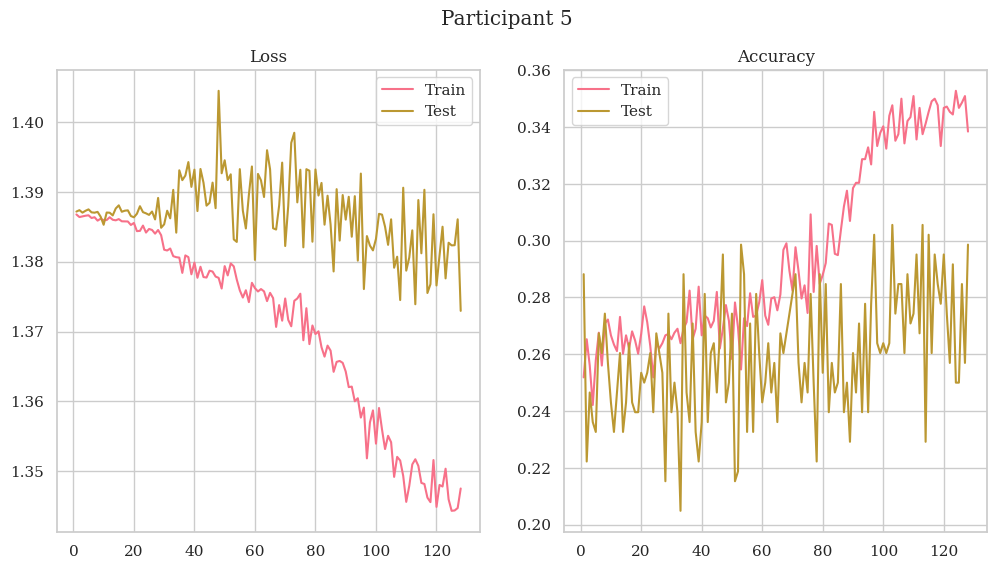

Outer Loop 2 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [2]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3861 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [  6/500] - Avg Training Loss: 1.3860 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 11/500] - Avg Training Loss: 1.3857 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

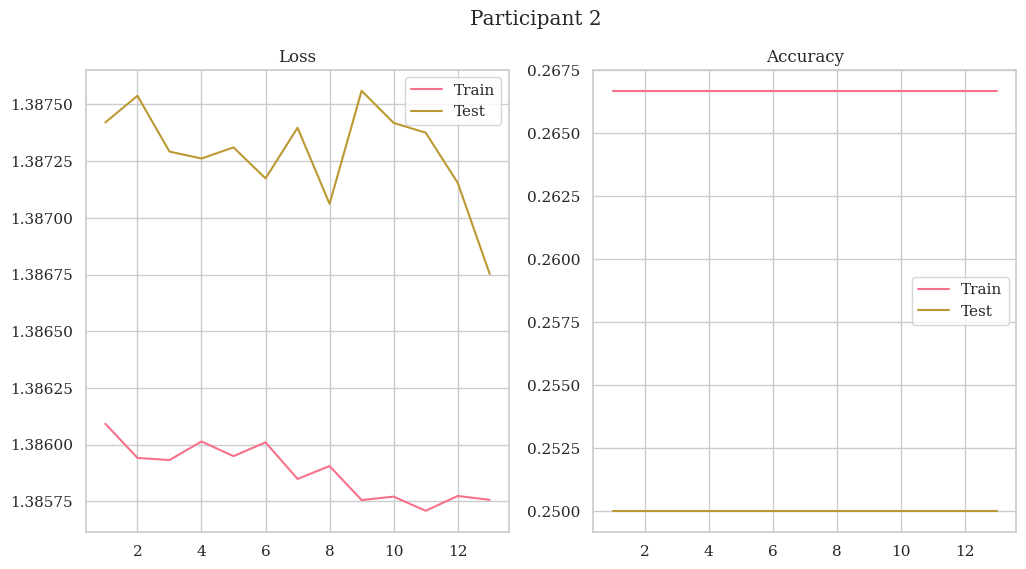

Outer Loop 3 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9]
      Test index:                                         [7]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3864 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [  6/500] - Avg Training Loss: 1.3857 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 11/500] - Avg Training Loss: 1.3850 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

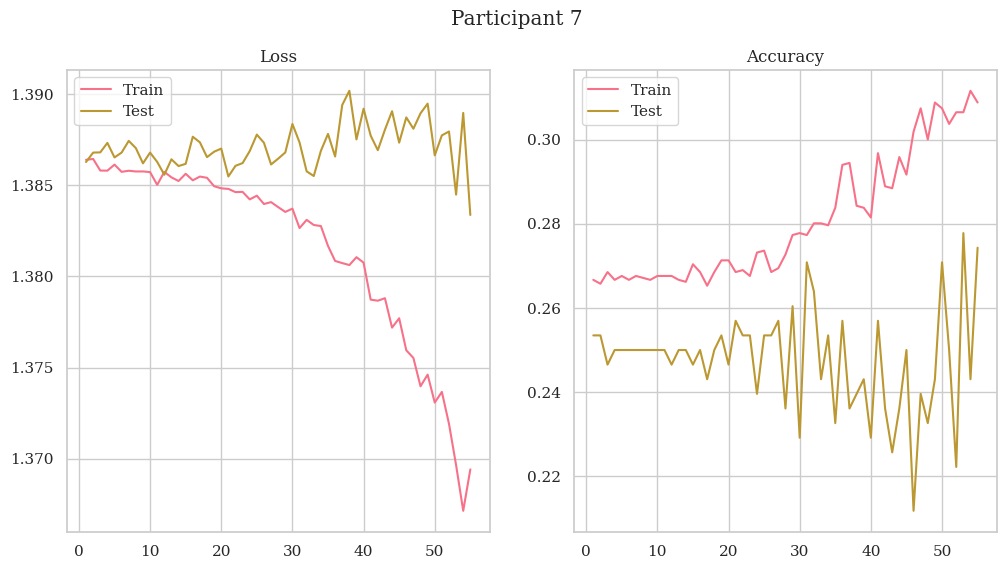

Outer Loop 4 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9]
      Test index:                                         [3]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3871 Train Accuracy: 0.25 - Test Loss: 1.39 - Test Accuracy: 0.24
Epoch [  6/500] - Avg Training Loss: 1.3868 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.26
Epoch [ 11/500] - Avg Training Loss: 1.3861 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.27
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

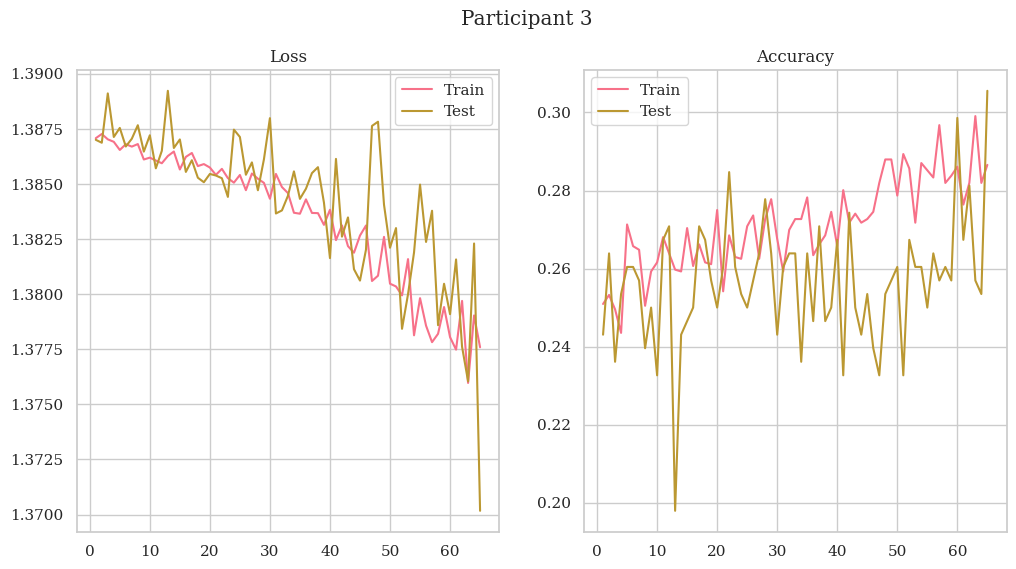

Outer Loop 5 

      Train epochs' shape:                                (2304, 1, 22, 1000)
      Test epochs' shape:                                 (144, 1, 22, 1000)
      Test labels' shape:                                 (144, 4)
      Train labels' shape (without encoding):             (2304, 1)
      Test labels' shape (without encoding):              (144, 1)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9]
      Test index:                                         [4]
      Train Features shape:                               (2304, 1, 16, 16)
      Test Features shape:                                (144, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3869 Train Accuracy: 0.25 - Test Loss: 1.41 - Test Accuracy: 0.00
Epoch [  6/500] - Avg Training Loss: 1.3866 Train Accuracy: 0.25 - Test Loss: 1.41 - Test Accuracy: 0.00
Epoch [ 11/500] - Avg Training Loss: 1.3864 Train Accuracy: 0.25 - Test Loss: 1.41 - Test Accuracy: 0.00
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

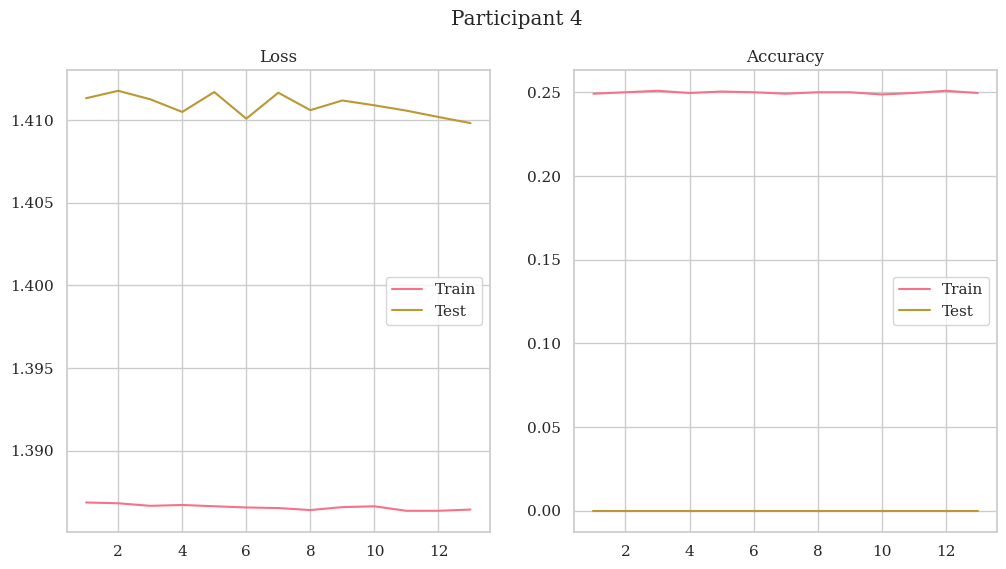

Outer Loop 6 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [1]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3848 Train Accuracy: 0.26 - Test Loss: 1.39 - Test Accuracy: 0.24
Epoch [  6/500] - Avg Training Loss: 1.3844 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.24
Epoch [ 11/500] - Avg Training Loss: 1.3843 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

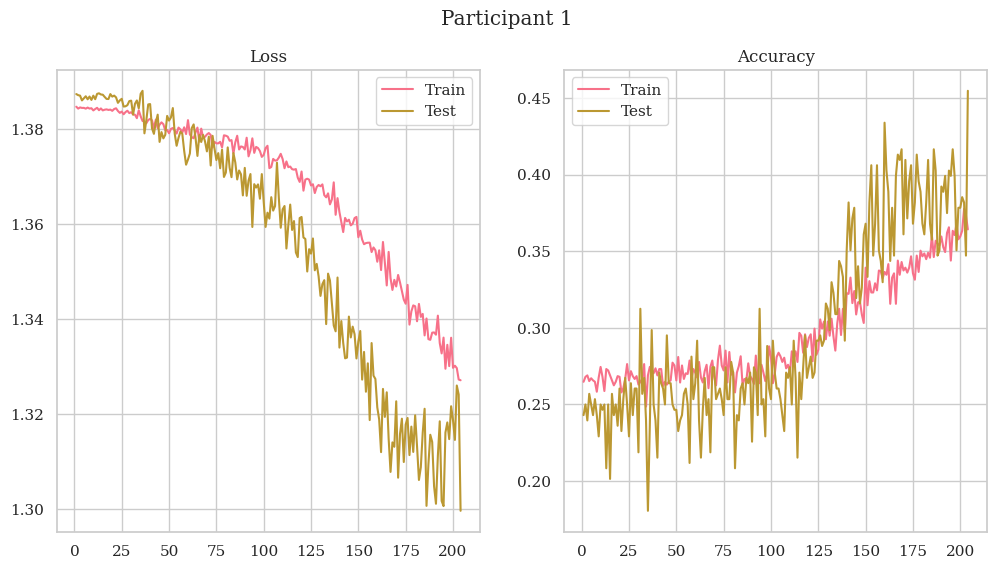

Outer Loop 7 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9]
      Test index:                                         [6]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3872 Train Accuracy: 0.24 - Test Loss: 1.39 - Test Accuracy: 0.26
Epoch [  6/500] - Avg Training Loss: 1.3867 Train Accuracy: 0.25 - Test Loss: 1.39 - Test Accuracy: 0.24
Epoch [ 11/500] - Avg Training Loss: 1.3862 Train Accuracy: 0.25 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

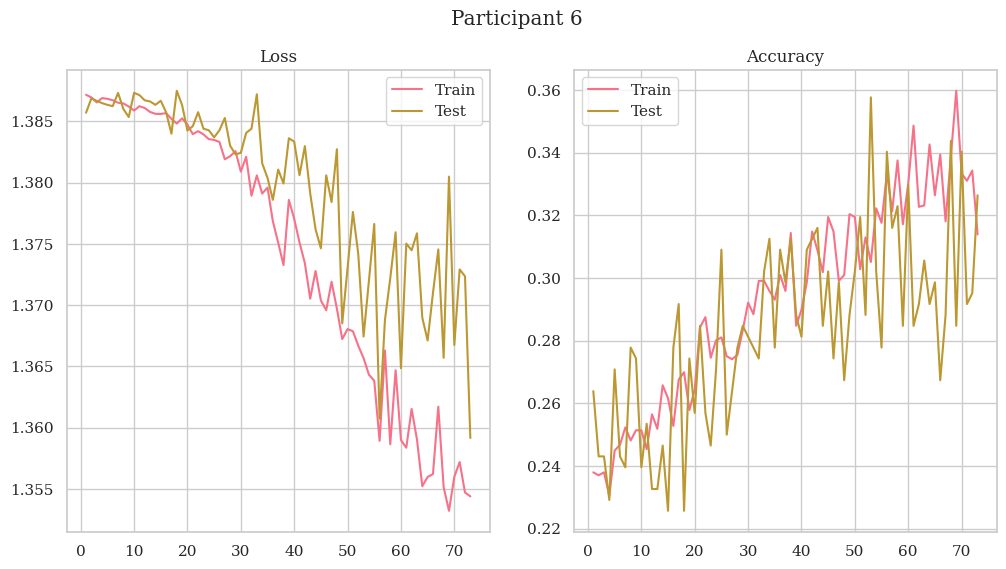

Outer Loop 8 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9]
      Test index:                                         [8]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3882 Train Accuracy: 0.23 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [  6/500] - Avg Training Loss: 1.3878 Train Accuracy: 0.23 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 11/500] - Avg Training Loss: 1.3876 Train Accuracy: 0.23 - Test Loss: 1.39 - Test Accuracy: 0.25
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

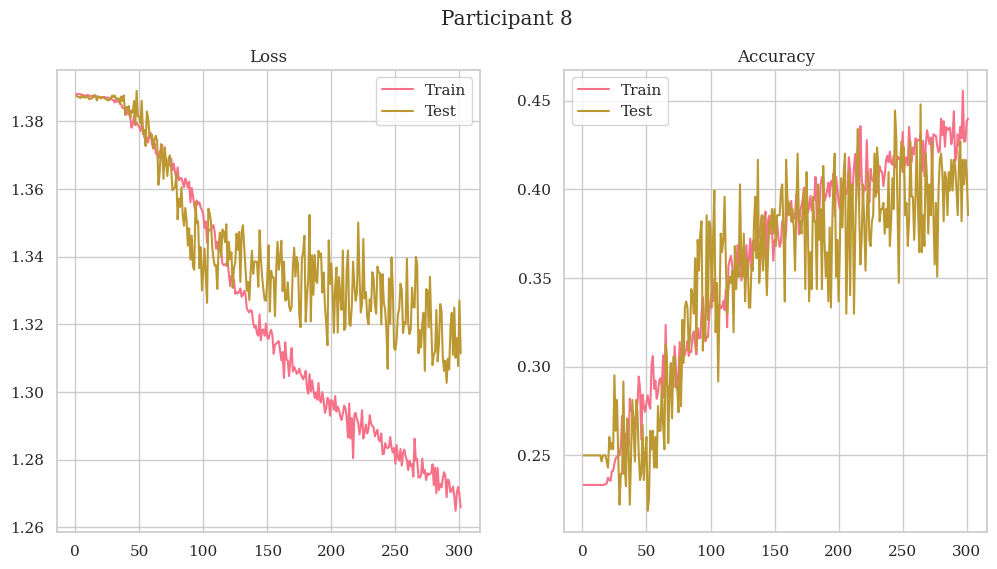

Outer Loop 9 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8]
      Test index:                                         [9]
      Train Features shape:                               (2160, 1, 16, 16)
      Test Features shape:                                (288, 1, 16, 16)



Epoch [  1/500] - Avg Training Loss: 1.3864 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.27
Epoch [  6/500] - Avg Training Loss: 1.3855 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.27
Epoch [ 11/500] - Avg Training Loss: 1.3850 Train Accuracy: 0.27 - Test Loss: 1.39 - Test Accuracy: 0.26
Epoch [ 16/500

<Figure size 640x480 with 0 Axes>

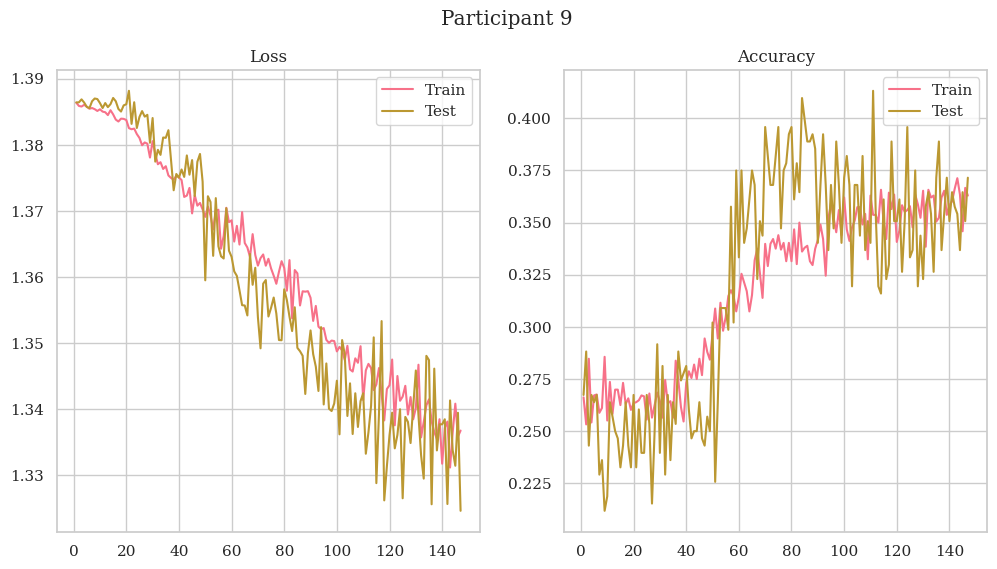

<Figure size 640x480 with 0 Axes>

In [35]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0001
#weight_decay=0.1*learning_rate
patience = 200

kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    with open("train_features_fortestID_{}_NoSlice.pickle".format(test_index[0]), "rb") as f:
        train_features = pickle.load(f)
        f.close()
    
    with open("test_features_fortestID_{}_NoSlice.pickle".format(test_index[0]), "rb") as f:
        test_features = pickle.load(f)
        f.close()
        
    train_features_4d = np.expand_dims(train_features, 1)
    test_features_4d = np.expand_dims(test_features, 1)
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print("      Train Features shape:                              ", train_features_4d.shape)
    print("      Test Features shape:                               ", test_features_4d.shape)

    print('\n\n')
    
    
    model = simple_CNN()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    model.to(device)
    model.train()
    
    
    best_metric = float('inf')
    counter = 1
    best_model_state = model.state_dict()
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    models = []
    for epoch in range(max_epochs):
        
        train_running_loss = 0
        y_true_temp = []
        y_pred_temp = []
        
        
        batch_size = 32
        fold_num = int(all_data_epochs[i].shape[0] // batch_size)
        stratified_kfold = StratifiedKFold(n_splits=fold_num, random_state=10, shuffle=True)
        
        for _, (_, train_batch_index) in enumerate(stratified_kfold.split(train_features_4d, no_encoded_train_labels)):
        
            batch_epoch, batch_label = train_features_4d[train_batch_index], train_labels[train_batch_index]
            batch_epoch, batch_label = torch.tensor(batch_epoch, dtype=torch.float32).to(device), torch.tensor(batch_label, dtype=torch.float32).to(device)
            optimizer.zero_grad()
            train_outputs = model(batch_epoch)
            loss = criterion(train_outputs, batch_label)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            y_pred_train = torch.argmax(train_outputs, 1).tolist()
            y_true_train = torch.argmax(batch_label, 1).tolist()
            y_true_temp.extend(y_true_train)
            y_pred_temp.extend(y_pred_train)
        
        
        with torch.no_grad():
                
            test_input_epoch, test_label_test = torch.tensor(test_features_4d).to(torch.float32).to(device), torch.tensor(test_labels).to(torch.float32).to(device)
            test_output = model(test_input_epoch)

            test_loss = criterion(test_output, test_label_test).item()
            y_pred_test = torch.argmax(test_output, 1).tolist()
            y_true_test = torch.argmax(test_label_test, 1).tolist()
            conf_mat = confusion_matrix(y_true_test, y_pred_test)
            test_accuracy = np.trace(conf_mat) / conf_mat.sum()

        train_conf_mat = confusion_matrix(y_true_temp, y_pred_temp)
        train_accuracy = np.trace(train_conf_mat) / train_conf_mat.sum()
        avg_train_loss = train_running_loss / fold_num
        
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)
        test_loss_epochs.append(test_loss)
        test_acc_epochs.append(test_accuracy)
        
        if epoch % 5 == 0:
            print(f"Epoch [{(epoch + 1): 3d}/{max_epochs}] - Avg Training Loss: {avg_train_loss:.4f} Train Accuracy: {train_accuracy:.2f} - Test Loss: {test_loss:.2f} - Test Accuracy: {test_accuracy:.2f}")
        
        if test_loss < best_metric:
            best_metric = test_loss
            best_model_state = model.state_dict()
            counter = 1
        else:
            counter += 1
        
        if counter > patience:
            break
        best_epoch = epoch-patience+2
        epochs_range = np.arange(1, len(train_loss_epochs[:best_epoch])+1)
        
        
        
        
    model.load_state_dict(best_model_state)
    models.append(best_model_state)
    with torch.no_grad():
                
        test_input_epoch, test_label_test = torch.tensor(test_features_4d).to(torch.float32).to(device), torch.tensor(test_labels).to(torch.float32).to(device)
        test_output = model(test_input_epoch)
        test_loss = criterion(test_output, test_label_test).item()
        y_pred_test = torch.argmax(test_output, 1).tolist()
        y_true_test = torch.argmax(test_label_test, 1).tolist()
        all_tests_true.append(y_true_test)
        all_tests_pred.append(y_pred_test)
        conf_mat = confusion_matrix(y_true_test, y_pred_test)
        test_accuracy = np.trace(conf_mat) / conf_mat.sum()
        
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:best_epoch])
    plt.plot(epochs_range, test_loss_epochs[:best_epoch])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:best_epoch])
    plt.plot(epochs_range, test_acc_epochs[:best_epoch])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [36]:
len(all_tests_pred[2])

288

In [37]:
confusion_matrices = []
for i in range(len(all_tests_pred)):
    if i == 3:
        continue
    y_true = all_tests_true[i]
    y_pred = all_tests_pred[i]
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [38]:
len(confusion_matrices)

8

In [39]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
acc = np.sum(summation / 576 * np.eye(4, 4)).sum() / 4


In [40]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      504
Tongue (True)    504
dtype: int64

In [41]:
acc

0.27994791666666663

In [42]:
print("The cross-subject scenario:")
print("Algorithm: Feature-based CNN")
print("Accuracy: ", acc)

summation / 576

The cross-subject scenario:
Algorithm: Feature-based CNN
Accuracy:  0.27994791666666663


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.411458,0.152778,0.173611,0.262153
Right (True),0.309028,0.175347,0.178819,0.336806
Feet (True),0.250000,0.154514,0.197917,0.272569
Tongue (True),0.230903,0.149306,0.159722,0.335069


In [90]:
print(123)

In [88]:
summation / 780 * 100

,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),32.948718,20.769231,14.615385,5.512821
Right (True),30.128205,21.282051,11.794872,10.641026
Feet (True),23.076923,18.333333,10.641026,12.564103
Tongue (True),15.512821,12.564103,20.897436,15.641026


In [ ]:
import pickle
with open("3class_all_tests_pred", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("3class_all_tests_true", "wb") as fp:
    pickle.dump(all_tests_true, fp)

    
print(all_tests_pred[1][1].shape)
print(all_tests_pred[12][1].shape)

In [ ]:
with open("3class_all_tests_pred", "rb") as fp:
    rand_var = pickle.load(fp)

    
with open("3class_all_tests_true", "rb") as fp:
    rand_var2 = pickle.load(fp)
print(rand_var[12][1].shape)
print(rand_var2[12][1].shape)

In [ ]:
all_tests_pred[1][2].shape

In [ ]:
np.argmax(all_tests_true[12][1], axis=1)+1

In [ ]:
a = np.array([[1, 2, 3], [4, 50, 6]])
np.sum(a, axis=1)

In [ ]:
y_true

In [ ]:
confusion_matrices_ap = []
y_pred_prob = []
for i in range(len(all_tests_pred)):
    y_pred = np.zeros(all_tests_true[i][0].shape)
    for j in range(len(all_tests_pred[1])):
        y_pred += all_tests_pred[i][j]
    y_pred_prob.append(y_pred/6)
    confusion_matrices_ap.append(confusion_matrix(np.argmax(all_tests_true[i][0], axis=1)+1, np.argmax(y_pred_prob[i], axis=1)+1))

In [ ]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)', 'class 3 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)', 'class 3 (Pred)'])
summation

In [ ]:
total_samples = summation.values.sum()
correct_predictions = summation.values.trace()
overall_accuracy = correct_predictions / total_samples

# Calculate accuracy for each class
class_accuracy = summation.values.diagonal() / summation.sum(axis=1)

# Print results
print(f"Overall Accuracy: {overall_accuracy:.2%}")

for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for Class {i + 1}: {acc:.2%}")

In [ ]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


In [ ]:
summation / (13 * 40) * 100

In [ ]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred)
class 1 (True),358,162
class 2 (True),202,315


In [31]:
summation / 520

,class 1 (Pred),class 2 (Pred)
class 1 (True),0.688462,0.311538
class 2 (True),0.388462,0.605769


In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

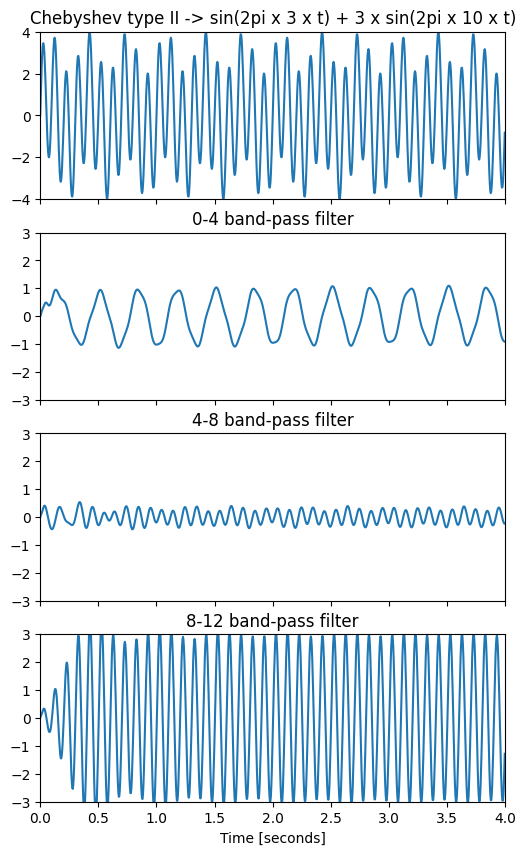

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


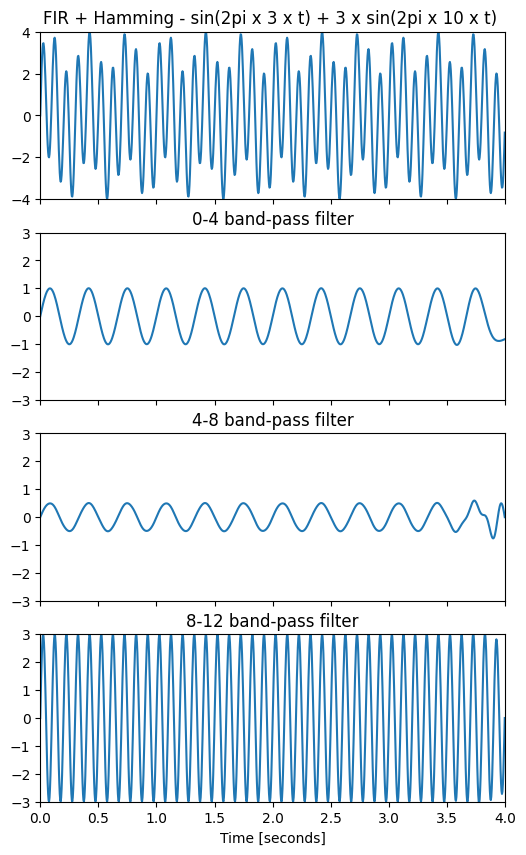

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

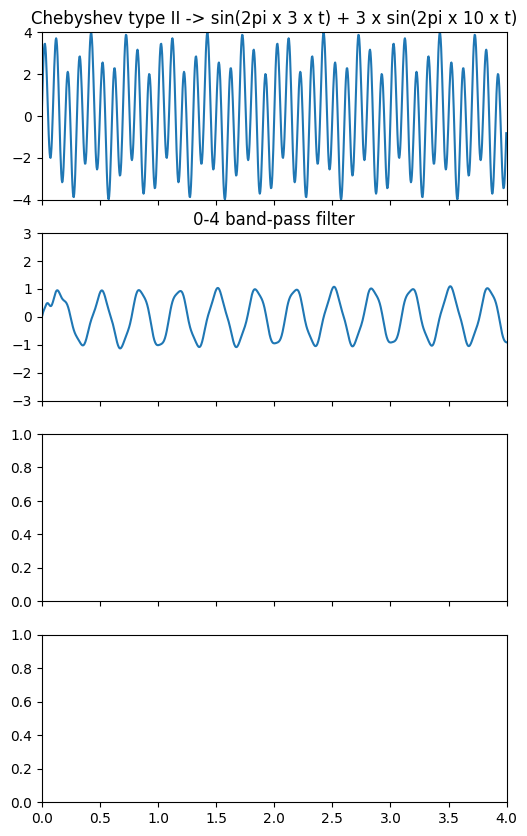

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

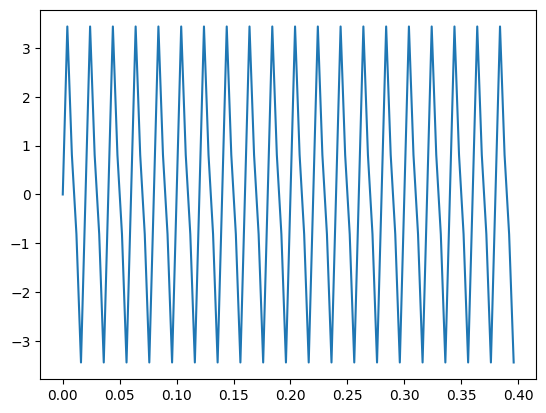

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

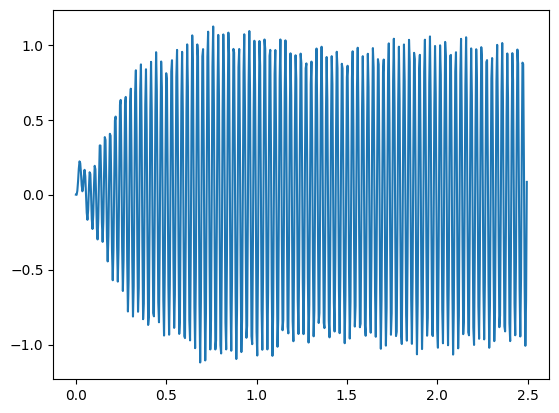

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

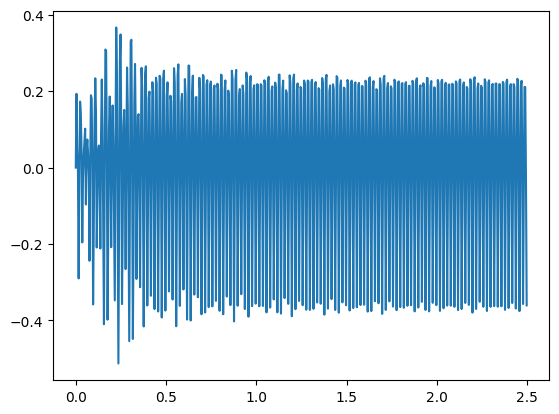

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

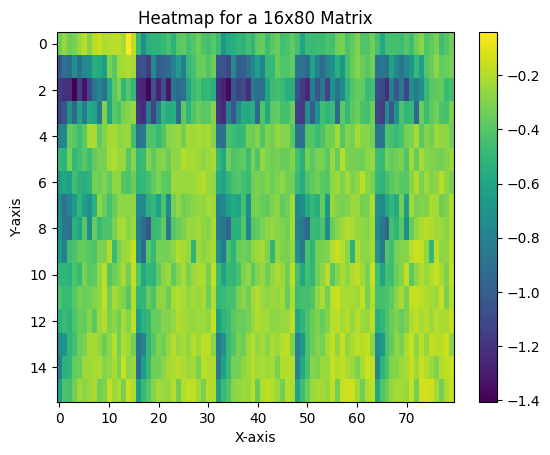

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

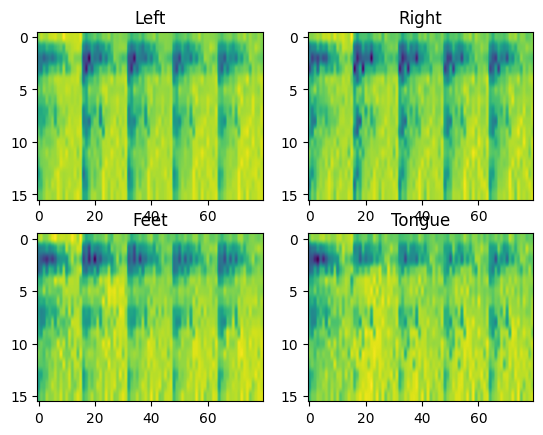

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()